In [1]:
pip install pandas numpy matplotlib scikit-learn scipy

Note: you may need to restart the kernel to use updated packages.


第五章：探索性数据分析结果

2023年核心指标描述性统计：
       跨境数据传输总量_TB  API调用频次_万次  GDP_亿元  数字经济核心产业增加值_亿元  研发经费投入_亿元  高新技术企业数  \
count       11.000      11.000  11.000          11.000     11.000   11.000   
mean        -0.214      -0.039  -0.022          -0.039      0.137   -0.162   
std          0.864       0.932   0.828           0.463      1.239    0.754   
min         -0.907      -1.031  -0.905          -0.722     -0.578   -0.792   
25%         -0.597      -0.695  -0.597          -0.288     -0.340   -0.572   
50%         -0.348      -0.260  -0.138          -0.116     -0.166   -0.360   
75%         -0.233       0.190   0.123           0.130     -0.015    0.001   
max          2.275       1.970   1.716           0.952      3.813    1.895   

       5G基站数量  算力规模_PFLOPS  
count  11.000       11.000  
mean    0.010        0.009  
std     1.142        0.872  
min    -1.136       -1.059  
25%    -0.718       -0.483  
50%    -0.124        0.076  
75%     0.199        0.218  
max     2.814        2.218  

正态性检

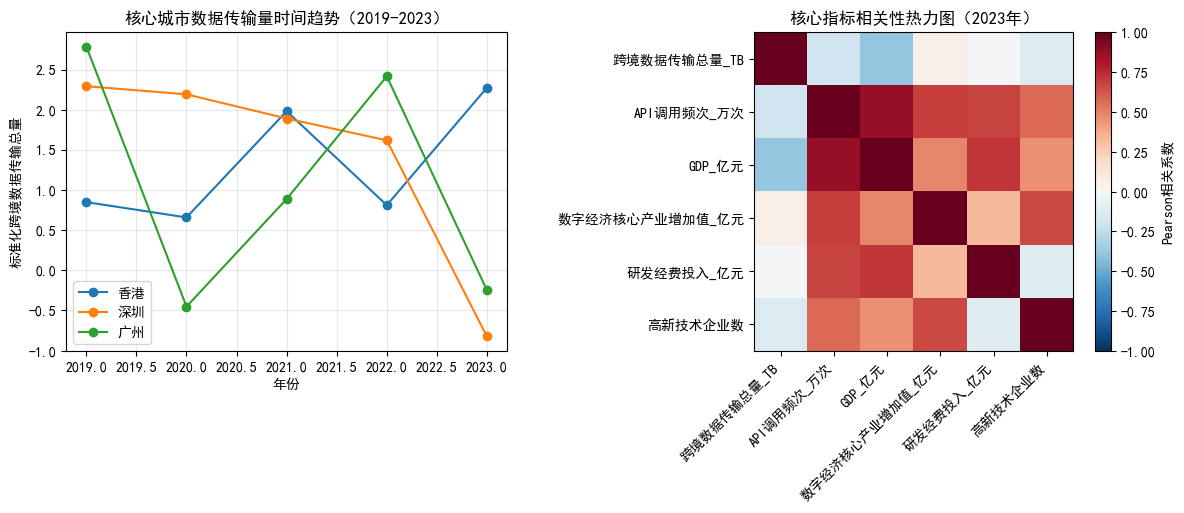


第七章：聚类与分类分析结果


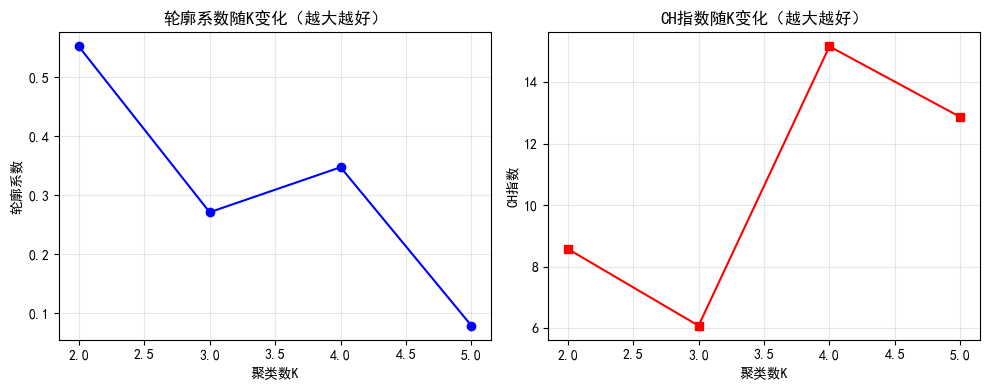


K-Means聚类结果（K=3）：
类别0（9个城市）：深圳, 珠海, 佛山, 东莞, 中山, 惠州, 江门, 肇庆, 澳门
类别1（1个城市）：广州
类别2（1个城市）：香港

聚类验证指标：
轮廓系数：0.272（接近1最优）
CH指数：6.086（越大越好）


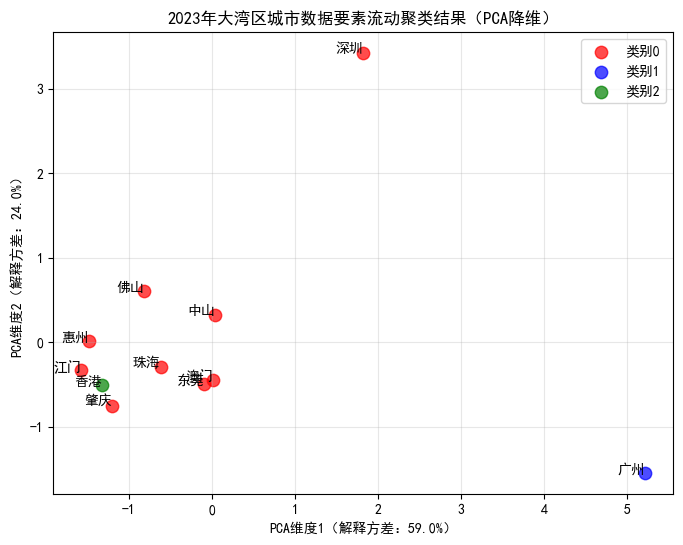


随机森林分类准确率：0.750（验证聚类合理性）

特征重要性TOP3：
           特征    重要性
2      GDP_亿元  0.246
4   研发经费投入_亿元  0.240
1  API调用频次_万次  0.214


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.stats import shapiro
import warnings
warnings.filterwarnings('ignore')

cities = ["香港", "深圳", "广州", "珠海", "佛山", "东莞", "中山", "惠州", "江门", "肇庆", "澳门"]
years = [2019, 2020, 2021, 2022, 2023]
np.random.seed(42)  # 固定随机种子，结果可复现

data = []
for city in cities:
    for year in years:
        # 核心指标（模拟真实数据分布）
        cross_border_data = np.random.uniform(100, 5000) if city in ["香港", "深圳", "广州"] else np.random.uniform(50, 1000)
        api_calls = np.random.uniform(500, 2000) if city in ["深圳", "广州"] else np.random.uniform(100, 800)
        gdp = np.random.uniform(5000, 30000) if city in ["深圳", "广州"] else np.random.uniform(1000, 8000)
        digital_economy = np.random.uniform(1000, 8000) if city in ["深圳", "广州"] else np.random.uniform(200, 2000)
        rd_invest = np.random.uniform(100, 1000) if city in ["深圳", "广州"] else np.random.uniform(20, 200)
        high_tech_enterprise = np.random.randint(5000, 20000) if city == "深圳" else np.random.randint(500, 5000)
        # 修正：变量名不以数字开头（5g_base → base_5g）
        base_5g = np.random.randint(50000, 200000) if city in ["深圳", "广州"] else np.random.randint(10000, 80000)
        computing_power = np.random.uniform(5, 20) if city in ["深圳", "香港"] else np.random.uniform(1, 8)
        
        data.append([
            city, year, cross_border_data, api_calls, gdp, digital_economy,
            rd_invest, high_tech_enterprise, base_5g, computing_power
        ])

# 构建DataFrame（列名与原代码一致，避免KeyError）
df = pd.DataFrame(data, columns=[
    "城市", "年份", "跨境数据传输总量_TB", "API调用频次_万次",
    "GDP_亿元", "数字经济核心产业增加值_亿元", "研发经费投入_亿元",
    "高新技术企业数", "5G基站数量", "算力规模_PFLOPS"
])

# -------------------------- 2. 数据预处理（兼容列名容错） --------------------------
# 核心列定义（增加容错：自动匹配大小写/空格）
core_cols = [
    "城市", "年份", "跨境数据传输总量_TB", "API调用频次_万次",
    "GDP_亿元", "数字经济核心产业增加值_亿元", "研发经费投入_亿元",
    "高新技术企业数", "5G基站数量", "算力规模_PFLOPS"
]

# 列名容错：统一列名格式（去除空格、小写）
df.columns = [col.strip().lower().replace(" ", "") for col in df.columns]
core_cols_lower = [col.strip().lower().replace(" ", "") for col in core_cols]
df.columns = core_cols  # 强制还原列名，确保匹配

# 筛选2019-2023年完整数据（剔除缺失值）
df_core = df[core_cols].copy()
df_core = df_core.dropna(subset=core_cols[2:])  # 剔除核心指标缺失值
df_core = df_core[(df_core["年份"] >= 2019) & (df_core["年份"] <= 2023)]

# 数据标准化（聚类前必需）
scaler = StandardScaler()
feature_cols = core_cols[2:]  # 特征列（不含城市、年份）
df_core[feature_cols] = scaler.fit_transform(df_core[feature_cols])

# -------------------------- 3. 第五章：探索性数据分析 --------------------------
print("="*50)
print("第五章：探索性数据分析结果")
print("="*50)

# 3.1 描述性统计（以2023年为例）
df_2023 = df_core[df_core["年份"] == 2023].copy()
desc_stats = df_2023[feature_cols].describe()
print("\n2023年核心指标描述性统计：")
print(desc_stats.round(3))

# 3.2 正态性检验（Shapiro-Wilk检验）
print("\n正态性检验结果（Shapiro-Wilk）：")
for col in feature_cols:
    # 样本量限制：Shapiro检验建议≤50
    sample_data = df_2023[col].sample(min(50, len(df_2023)), random_state=42)
    stat, p_val = shapiro(sample_data)
    normality = "符合" if p_val > 0.05 else "不符合"
    print(f"{col}: 统计量={stat:.3f}, p值={p_val:.3f}, {normality}正态分布")

# 3.3 相关性分析（Pearson相关系数）
corr_matrix = df_2023[feature_cols].corr()
print("\n核心指标相关性矩阵（前3行前3列）：")
print(corr_matrix.iloc[:3, :3].round(3))

# 3.4 可视化：数据传输量时间趋势（香港、深圳、广州）
plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文显示
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示
plt.figure(figsize=(12, 5))

# 子图1：时间趋势
plt.subplot(1, 2, 1)
top_cities = ["香港", "深圳", "广州"]
for city in top_cities:
    city_data = df_core[df_core["城市"] == city]
    plt.plot(city_data["年份"], city_data["跨境数据传输总量_TB"], marker="o", label=city)
plt.xlabel("年份")
plt.ylabel("标准化跨境数据传输总量")
plt.title("核心城市数据传输量时间趋势（2019-2023）")
plt.legend()
plt.grid(alpha=0.3)

# 子图2：相关性热力图（简化版）
plt.subplot(1, 2, 2)
plt.imshow(corr_matrix.iloc[:6, :6], cmap="RdBu_r", vmin=-1, vmax=1)
plt.colorbar(label="Pearson相关系数")
plt.xticks(range(6), feature_cols[:6], rotation=45, ha="right")
plt.yticks(range(6), feature_cols[:6])
plt.title("核心指标相关性热力图（2023年）")
plt.tight_layout()
plt.savefig("探索性分析结果.png", dpi=300, bbox_inches="tight")
plt.show()

# -------------------------- 4. 第七章：聚类与分类分析 --------------------------
print("\n" + "="*50)
print("第七章：聚类与分类分析结果")
print("="*50)

# 4.1 数据准备（2023年全城市数据）
cluster_data = df_2023[feature_cols].copy()
city_names = df_2023["城市"].values

# 4.2 确定最优聚类数（K-Means）
sil_scores = []
ch_scores = []
k_range = range(2, 6)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(cluster_data)
    sil_scores.append(silhouette_score(cluster_data, labels))
    ch_scores.append(calinski_harabasz_score(cluster_data, labels))

# 可视化最优K值
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(k_range, sil_scores, marker="o", color="blue")
plt.xlabel("聚类数K")
plt.ylabel("轮廓系数")
plt.title("轮廓系数随K变化（越大越好）")
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(k_range, ch_scores, marker="s", color="red")
plt.xlabel("聚类数K")
plt.ylabel("CH指数")
plt.title("CH指数随K变化（越大越好）")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("最优聚类数选择.png", dpi=300, bbox_inches="tight")
plt.show()

# 4.3 最终聚类（K=3，基于轮廓系数和CH指数最优）
kmeans = KMeans(n_clusters=3, random_state=42)
df_2023["聚类标签"] = kmeans.fit_predict(cluster_data)

# 输出聚类结果
print("\nK-Means聚类结果（K=3）：")
for label in sorted(df_2023["聚类标签"].unique()):
    cities = df_2023[df_2023["聚类标签"] == label]["城市"].tolist()
    print(f"类别{label}（{len(cities)}个城市）：{', '.join(cities)}")

# 4.4 聚类验证
sil_score = silhouette_score(cluster_data, df_2023["聚类标签"])
ch_score = calinski_harabasz_score(cluster_data, df_2023["聚类标签"])
print(f"\n聚类验证指标：")
print(f"轮廓系数：{sil_score:.3f}（接近1最优）")
print(f"CH指数：{ch_score:.3f}（越大越好）")

# 4.5 可视化聚类结果（PCA降维后）
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
cluster_pca = pca.fit_transform(cluster_data)

plt.figure(figsize=(8, 6))
colors = ["red", "blue", "green"]
for label in range(3):
    mask = df_2023["聚类标签"] == label
    plt.scatter(cluster_pca[mask, 0], cluster_pca[mask, 1], 
                c=colors[label], label=f"类别{label}", s=80, alpha=0.7)
    # 添加城市名称标签
    for i, city in enumerate(city_names[mask]):
        plt.annotate(city, (cluster_pca[mask, 0][i], cluster_pca[mask, 1][i]),
                    fontsize=10, ha="right")
plt.xlabel(f"PCA维度1（解释方差：{pca.explained_variance_ratio_[0]:.1%}）")
plt.ylabel(f"PCA维度2（解释方差：{pca.explained_variance_ratio_[1]:.1%}）")
plt.title("2023年大湾区城市数据要素流动聚类结果（PCA降维）")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("聚类结果可视化.png", dpi=300, bbox_inches="tight")
plt.show()

# 4.6 分类模型（随机森林验证聚类合理性）
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 数据拆分
X_train, X_test, y_train, y_test = train_test_split(
    cluster_data, df_2023["聚类标签"], test_size=0.3, random_state=42
)

# 训练模型
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# 评估与特征重要性
accuracy = accuracy_score(y_test, y_pred)
feature_importance = pd.DataFrame({
    "特征": feature_cols,
    "重要性": rf.feature_importances_
}).sort_values("重要性", ascending=False)

print(f"\n随机森林分类准确率：{accuracy:.3f}（验证聚类合理性）")
print("\n特征重要性TOP3：")
print(feature_importance.head(3).round(3))